In [288]:
# *************************        Phase0: packages & methods *****************************
import datetime
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ML
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

# data analysis methods:
def info_print(header, content):
    print(header, ': **************************************************************************\n', content, '\n')
    
def value_counts(df):
    for fea in df.columns:
        print(df[fea].value_counts())
        
def group_comparison(df, label, features):
    for fea in features:
        print(df[[fea, label]].groupby([fea], as_index=False).agg(['mean', 'count']))
    
def facet_grid(df, label):
    for fea in df.columns:
        if fea != label :
            grid = sns.FacetGrid(df, col=label)
            grid.map(plt.hist, fea, bins=20)
            plt.show()
            
def box_report(df):
    for fea in df.columns:
        if fea != label :
            sns.boxplot(x = fea, data=df)
            plt.show()
    
def corr_heatmap(df, label, k, show):
    corr = train_data.corr()
    sns.heatmap(corr, vmax=.8, square=True)
    plt.show()
    if show:
        print(round(corr, 2))
    cols = corr.nlargest(k, label)[label].index
    print('Top', k, cols)
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    
def null_report(df):
    print('Null Statistics: **************************************************************************')
    print('COLUMN'.ljust(20), 'NULL CNT'.ljust(20), 'NULL RATE')
    for i in df.columns:
        d=len(df) - df[i].count()
        r=(d / len(df)) * 100
        rate='%.2f%%' % r
        print(str(i).ljust(20), str(d).ljust(20), rate)

# feature engineering methods:  
def tv_split(train_data, t_ratio):
    random.seed(23)
    train_data['rand'] = train_data[label].apply(lambda x: random.random())
    # T - training set, V - validation set
    train_data_T = train_data[train_data.rand <= t_ratio]
    train_data_V = train_data[train_data.rand > t_ratio]
    return train_data_T, train_data_V

def feature_engineering(df, label, features, features_np):
    y = ''
    if label in df.columns:
        y = df[label]
     
    X = df[features]
    null_process2(X, features_np)
    
    # special engineering
    if 'Name' in features:
        X["Name"] = X["Name"].apply(getName)
    X["FimalySize"] = X["SibSp"] + X["Parch"] + 1
    X["Age"] = X["Age"].apply(lambda x: 1 if x < 15 else 0)
    
    X = pd.get_dummies(X)

    return X, y

def getName(name):
    if "Mr" in str(name):
        return 1
    elif "Mrs" in str(name):
        return 2
    else:
        return 0     
# def null_process(train_data, test_data, cols):
#     for col in cols:
#         train_data[col] = train_data[col].fillna(train_data[col].mean())
#         test_data[col] = test_data[col].fillna(train_data[col].mean())
        
def null_process2(df, cols):
    for col in cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

# training methods:
def training_pipeline(X_train, y_train, model_map):
    for k in model_map.keys():
        model = model_map[k]
        model.fit(X_train, y_train)

        
# evaluation methods:
def evaluate_pipeline(X_valid, y_valid, model_map):
    for k in model_map.keys():
        model = model_map[k]
        print(k, "---Model Evaluation Report: ", model)
        evaluate(model, X_valid, y_valid)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.clf()
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.show()
    
def evaluate_binary_clf_prob(y_actual, y_prob):
    plt.clf()
    precisions, recalls, thresholds = precision_recall_curve(y_actual, y_prob)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    plt.plot(fpr, tpr, marker='.')
    auc = roc_auc_score(y_actual, y_prob)
    print('auc: ', auc)
    plt.show()

def evaluate_binary_clf_bin(y_actual, y_bin):
    plt.clf()
    print(confusion_matrix(y_actual, y_bin))
    print('precision: ', precision_score(y_actual, y_bin))
    print('recall: ', recall_score(y_actual, y_bin))
    print('f1-score: ', f1_score(y_actual, y_bin))
    
def evaluate(model, X, y):
    y_reg = model.predict(X)
#     y_prob = model.predict_proba(X)[::,1]
#     evaluate_binary_clf_bin(y, y_bin)
#     evaluate_binary_clf_prob(y, y_prob)
    evaluate_reg(y, y_reg)
    
def evaluate_reg(y_actual, y_reg):
    print('Mean Absolute Error:', mean_absolute_error(y_actual, y_reg))  
    print('Mean Squared Error:', mean_squared_error(y_actual, y_reg))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_actual, y_reg)))
#     print('Root Mean Squared Log Error:', np.sqrt(mean_squared_log_error(y_actual, y_reg)))    
    
    

# feature engineering attempts

# # 14 Categorical cols:
# LotShape: Reg -> 0, Else -> 1 #
# HouseStyle: [2.5Fin, 2Story] -> 2, 1Story -> 1, Else -> 0 #
#1 Exterior1st, Exterior2nd: [VinylSd,ImStucc,CmentBd,CemntBd,Stone,BrkFace,Other] -> 2, 
#2 [HdBoard, MetalSd, Wd Sdng, Plywood] -> 1, Else -> 0 #
# MasVnrType: Stone -> 2, BrkFace -> 1, Else -> 0 #
# ExterQual, BsmtQual, HeatingQC, KitchenQual: [Ex, Gd] -> 1, Else -> 0 #
# Foundation: PConc -> 1, Else -> 0 #
# BsmtExposure: No -> 0, Else -> 1 #
# BsmtFinType1: GLQ -> 2, Unf -> 1, Else -> 0 #
# GarageType: [Attchd, BuiltIn] -> 1, Else -> 0 #
# GarageFinish: Fin -> 2, RFn -> 1, Else -> 0

# # 24 Numerical cols:
# BsmtFullBath, HalfBath, Fireplaces, MasVnrArea, 2ndFlrSF, WoodDeckSF, OpenPorchSF: 0 -> 0, Else -> 1
# FullBath: <=1 -> 0, Else -> 1
# OverallQual, TotRmsAbvGrd, GarageCars: -
# OverallCond, BedroomAbvGr: - ? a little bit abnormal
#1 YearBuilt, YearRemodAdd, BsmtUnfSF, TotalBsmtSF, LotFrontage, BsmtFinSF1
#2 1stFlrSF, GrLivArea, GarageYrBlt, GarageArea, LotArea: - ? very discrete, could be binned

# # 
# top_k_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
#        'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

def feature_engineering_house_prices(df, label, features, numerical_cols):
    y = ''
    if label in df.columns:
        y = df[label]
    # # 14 Categorical cols:
#     dummy
#     df['LotShape'] = df['LotShape'].apply(lambda x: 0 if x.strip() == 'Reg' else 1)
#     df['HouseStyle'] = df['HouseStyle'].apply(lambda x: 2 if x in ['2.5Fin', '2Story'] 
#                                               else (1 if x == '1Story' else 0))
#     for col in ['Exterior1st', 'Exterior2nd']:
#         df[col] = df[col].apply(lambda x: 2 if x in ['VinylSd', 'ImStucc', 'CmentBd', 'CemntBd', 'BrkFace', 'Other'] 
#                                 else (1 if x in ['HdBoard', 'MetalSd', 'Wd Sdng', 'Plywood'] else 0))
#     df['MasVnrType'] = df['MasVnrType'].apply(lambda x: 2 if x == 'Stone' else (1 if x == 'BrkFace' else 0))
#     for col in ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual']:
#         df[col] = df[col].apply(lambda x: 1 if x in ['Ex', 'Gd'] else 0)
#     df['Foundation'] = df['Foundation'].apply(lambda x: 1 if x == 'PConc' else 0)
#     df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x: 0 if x == 'No' else 1)
#     df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda x: 2 if x == 'GLQ' 
#                                               else (1 if x == 'Unf' else 0))
#     df['GarageType'] = df['GarageType'].apply(lambda x: 1 if x in ['Attchd', 'BuiltIn'] else 0)
#     df['GarageFinish'] = df['GarageFinish'].apply(lambda x: 2 if x == 'Fin' 
#                                               else (1 if x == 'RFn' else 0))
    # # 24 Numerical cols:
    
    X = df[features]
    null_process2(X, numerical_cols)
    
    X = pd.get_dummies(X)

    return X, y
def null_process_cn(df, categorical_cols, numerical_cols):
    for col in categorical_cols:
        df[col] = df[col].fillna('None')
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

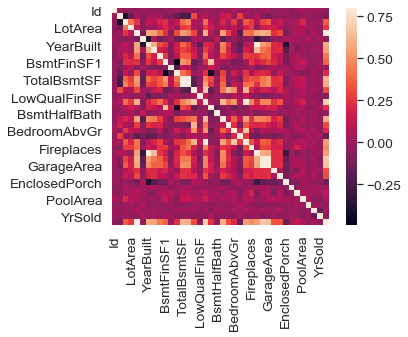

Top 10 Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')


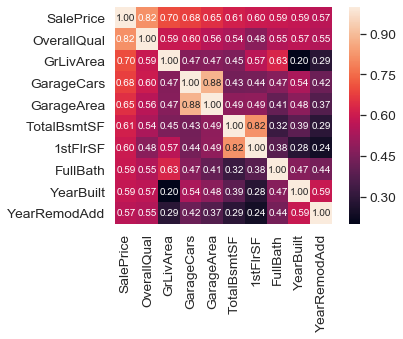

Size of all_col: 81
Size of key_cols: 2
Size of overmissing_cols: 5
Size of nonuniform_cols: 32
Size of categorical_cols:  14
Size of numerical_cols: 24
Size of tbd_cols: 4
['LotShape', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'LotFrontage', 'BsmtFinSF1']
38
             SalePrice      
                  mean count
OverallQual                 
1            10.798825     2
2            10.825404     3
3            11.337487    20
4            11.557158   116
5            11.780665   397
6            11.967315   374
7            12.221778   31

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 38 columns):
LotShape        2919 non-null object
HouseStyle      2919 non-null object
Exterior1st     2918 non-null object
Exterior2nd     2918 non-null object
MasVnrType      2895 non-null object
ExterQual       2919 non-null object
Foundation      2919 non-null object
BsmtQual        2838 non-null object
BsmtExposure    2837 non-null object
BsmtFinType1    2840 non-null object
HeatingQC       2919 non-null object
KitchenQual     2918 non-null object
GarageType      2762 non-null object
GarageFinish    2760 non-null object
OverallQual     2919 non-null int64
OverallCond     2919 non-null int64
YearBuilt       2919 non-null int64
YearRemodAdd    2919 non-null int64
MasVnrArea      2896 non-null float64
BsmtUnfSF       2918 non-null float64
TotalBsmtSF     2918 non-null float64
1stFlrSF        2919 non-null int64
2ndFlrSF        2919 non-null int64
GrLivArea       2919 non-null int64
BedroomAb

            SalePrice      
                 mean count
WoodDeckSF                 
-0.740760   11.901460   761
-0.645902   11.772330     2
-0.551044   12.118157     2
-0.535235   11.498171     2
-0.519425   11.708135     2
-0.503615   11.133143     1
-0.487806   11.820418     1
-0.479901   11.775297     1
-0.464091   11.842236     1
-0.456186   11.881213     4
-0.440377   12.233322     2
-0.424567   11.788730     3
-0.408757   11.820123     1
-0.392948   11.767575     1
-0.385043   11.794345     1
-0.361329   11.700079     5
-0.353424   11.492004     2
-0.329709   13.275829     1
-0.321804   11.344519     1
-0.305995   11.722634     2
-0.298090   12.406566     1
-0.290185   11.813037     1
-0.282280   11.705446     2
-0.266471   12.373407     2
-0.242756   12.141539     1
-0.234851   11.774486     4
-0.219042   11.719948     1
-0.203232   11.678526     2
-0.187422   11.967187     1
-0.171613   11.944918     3
...               ...   ...
 2.587174   11.694422     1
 2.626698   11.84940

In [289]:
train_data = pd.read_csv("input/train.csv")
label = 'SalePrice'
train_data[label] = np.log1p(train_data[label])
print(train_data.info())
show_data_report = False
# show_data_report = True

if show_data_report:
    info_print('DATA DESCRIBE', round(train_data.describe(), 2))
    info_print('DATA HEAD', train_data.head(5))

all_cols = train_data.columns.tolist()

corr_heatmap(train_data, label, 10, show_data_report)
top_k_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

key_cols = ['Id', 'SalePrice']
# to many null values
overmissing_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']
# screwed distribution
nonuniform_cols = ['MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope'
                  , 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'BsmtCond', 'BsmtFinType2'
                  , 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath'
                   , 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'RoofStyle'
                   , 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition'
                  , 'ExterCond']
# one-hot or binding 
categorical_cols = ['LotShape', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType'
               , 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1'
               , 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish']
# continuous
numerical_cols = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF'
            , 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd'
             , 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotArea'
                 , 'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'LotFrontage', 'BsmtFinSF1']
oversize_num_cols = ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                    'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'LotFrontage', 'BsmtFinSF1']
# to be decided
tbd_cols = ['Neighborhood', 'MoSold', 'YrSold', 'MSSubClass']

print('Size of all_col:', len(all_cols))
print('Size of key_cols:', len(key_cols))
print('Size of overmissing_cols:', len(overmissing_cols))
print('Size of nonuniform_cols:', len(nonuniform_cols))
print('Size of categorical_cols: ', len(categorical_cols))
print('Size of numerical_cols:', len(numerical_cols))
print('Size of tbd_cols:', len(tbd_cols))
# check
for col in remaining_cols:
    if col not in discard_cols + nonuniform_cols + categorical_cols + tbd_cols + numerical_cols:
        print(col)
        
useful_cols = categorical_cols + numerical_cols
print(useful_cols)
print(len(useful_cols))

group_comparison(train_data, label, numerical_cols)

if show_data_report:
#     box_report(train_data[continuous_feas])#todo: how to deal with outliers?
    null_report(train_data)
# facet_grid(train_data, label)
# feature_engineering_house_prices(train_data, label, categorical_cols)
features = categorical_cols + numerical_cols

test_data = pd.read_csv("input/test.csv")
y_train = train_data[label]
X_train = train_data[features]
X_test = test_data[features]

# feature engineering: null_process(cat/num) + num_scale + cat_get_dummies 
ntrain = X_train.shape[0]
X_all = pd.concat((X_train, X_test))
print(X_all.info())
null_process_cn(X_all, categorical_cols, numerical_cols)
print(X_all.info())

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
X_all[oversize_num_cols] = standard_scaler.fit_transform(X_all[oversize_num_cols])

X_all = pd.get_dummies(X_all)

X_train = X_all[:ntrain]
X_test = X_all[ntrain:]

final_features = X_train.columns
X_y = pd.concat([X_train, y_train], axis=1)

group_comparison(X_y, label, numerical_cols)

t_ratio = 0.6
train_data_T, train_data_V = tv_split(X_y, t_ratio)
X_train_T = train_data_T[final_features]
y_train_T = train_data_T[label]
X_train_V = train_data_V[final_features]
y_train_V = train_data_V[label]

print(X_train_T.shape)
print(y_train_T.shape)
print(X_train_V.shape)
print(y_train_V.shape)
print(X_test.shape)


In [ ]:
model_map = {}
# model_map['LR'] = LinearRegression()
# model_map['RF'] = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=1)
model_map['XGB'] = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators = 500, silent=True, objective='reg:squarederror')
model_map['XGB_GSCV'] = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators = 500, silent=True, objective='reg:squarederror'), 
                                     param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5], 'n_estimators': range(100, 1000, 100), 'max_depth': range(3, 15, 1)}, 
                                     scoring='neg_mean_squared_error', cv=5)


training_pipeline(X_train_T, y_train_T, model_map)
evaluate_pipeline(X_train_V, y_train_V, model_map)

best = 'XGB'

y_test = model_map[best].predict(X_test)
y_test = np.expm1(y_test)
output = pd.DataFrame({'Id': test_data.Id, 'SalePrice': y_test})
output_filename = 'output/' + best + '_' + str(datetime.datetime.now()) + '.csv'
output.to_csv(output_filename, index=False)
print('Your submission ' + output_filename + ' was successfully saved!')

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/mtdp1/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None

In [295]:
from sklearn import metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [202]:
print(X_train_T.columns)
print(model_map['LR'].coef_)
print(model_map['RF'].feature_importances_)

Index(['LotShape', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'LotArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'Fireplaces', 'LotFrontage', 'BsmtFinSF1'],
      dtype='object')
[ 1.56655509e+03  1.85301407e+03 -2.40393344e+03  2.62351720e+03
 -5.15169738e+02  8.86687665e+03  6.55589210e+03 -6.44313269e+03
  9.02633409e+03  2.80306173e+03  2.30924584e+03  3.81787954e+03
 -2.71419981e+03  1.76789886e+03  1.46924175e+04  6.44428913e+03
  2.21408056e+02  4.32778072e+01  1.48657545e+01 -1.84893016e+00
  2.26430260e+01  1.25306700e+01  1.25152468e+01  3.67522787e